In [7]:
import os

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import spatial

from operator import itemgetter

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [8]:
print("Available devices: %s" % tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Dataset

In [9]:
os.listdir('datasets')

X_train = np.load('datasets/k49-train-imgs.npz')['arr_0']
Y_train = np.load('datasets/k49-train-labels.npz')['arr_0']

X_test = np.load('datasets/k49-test-imgs.npz')['arr_0']
Y_test = np.load('datasets/k49-test-labels.npz')['arr_0']

label_map = pd.read_csv('datasets/k49_classmap.csv')

###############################
# !!! Balance the dataset !!! #
###############################

In [10]:
print(Y_test[:10])
print(label_map)

[19 23 10 31 26 12 24  9 24  8]
    index codepoint char
0       0    U+3042    あ
1       1    U+3044    い
2       2    U+3046    う
3       3    U+3048    え
4       4    U+304A    お
5       5    U+304B    か
6       6    U+304D    き
7       7    U+304F    く
8       8    U+3051    け
9       9    U+3053    こ
10     10    U+3055    さ
11     11    U+3057    し
12     12    U+3059    す
13     13    U+305B    せ
14     14    U+305D    そ
15     15    U+305F    た
16     16    U+3061    ち
17     17    U+3064    つ
18     18    U+3066    て
19     19    U+3068    と
20     20    U+306A    な
21     21    U+306B    に
22     22    U+306C    ぬ
23     23    U+306D    ね
24     24    U+306E    の
25     25    U+306F    は
26     26    U+3072    ひ
27     27    U+3075    ふ
28     28    U+3078    へ
29     29    U+307B    ほ
30     30    U+307E    ま
31     31    U+307F    み
32     32    U+3080    む
33     33    U+3081    め
34     34    U+3082    も
35     35    U+3084    や
36     36    U+3086    ゆ
37     37    U+308

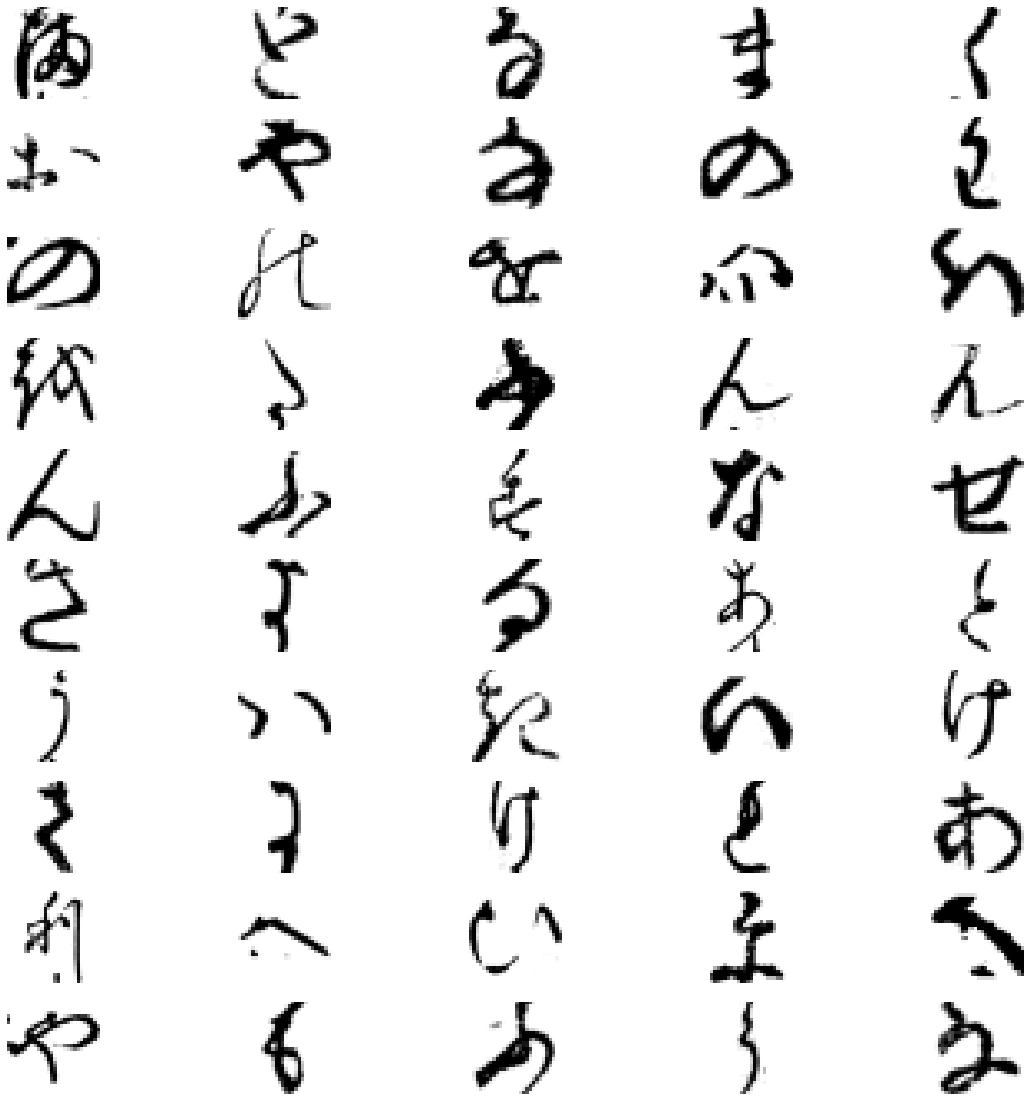

In [11]:
plt.figure(figsize=(20,20))
for i in range(0,50) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X_train[i].reshape(28,28), cmap="gray_r")

In [12]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1) / 255
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1) / 255

num_class = len(np.unique(Y_train))
                
Y_train = to_categorical(Y_train, num_class)
Y_test = to_categorical(Y_test, num_class)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.2, random_state = 100)

## Augmentation

Since we're woking with small (28x28x1) graysclade images containing hadwritten kanji, we can't apply horizontal or vertical flip, as well as a big rotation rotation (40+ degrees). It is because kanji are always written in the similar form and position, and definitely are not rotated or flipped any way.

That's why we decided to use horizontal/vertical shift equal to 10% of image size (~3 pixels) as well as zooming (10%). These transformations definitely will retain original kanji shape even if it is a bit shifted, zoomed in, or rotated a bit (10 degrees).

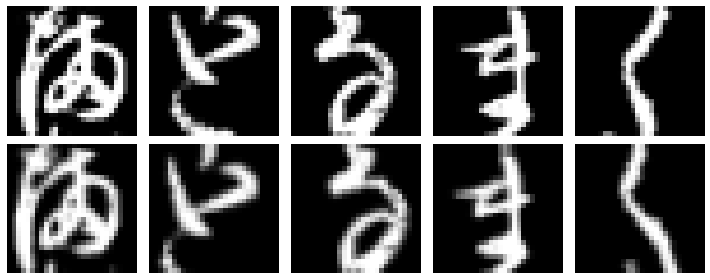

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# create an instance of ImageDataGenerator with augmentation options
datagen = ImageDataGenerator(
        width_shift_range=0.1,  # shift the image horizontally by 20% of the width
        height_shift_range=0.1,  # shift the image vertically by 20% of the height
        rotation_range=20,  # rotate the image by 20 degrees
        zoom_range=0.1,  # zoom in or out of the image by 20%
        fill_mode='nearest'  # fill any new pixels with the nearest pixel value
)

# # create a generator to generate augmented images from the in-memory images
# image_generator = datagen.flow(X_train, batch_size=1)

# plot some of the generated images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()

for i in range(5):
    aug_image = datagen.random_transform(
        X_train[i], seed=i
    )
    axs[i].imshow(X_train[i].squeeze(), cmap='gray')
    axs[i].axis('off')
    axs[i+5].imshow(aug_image.squeeze(), cmap='gray')
    axs[i+5].axis('off')
    
plt.tight_layout()
plt.show()

In [14]:
# add 0.1% of augmented data to the training dataset
for i in tqdm(range(int(len(X_train)/1000)), ncols=100):
    aug_image = datagen.random_transform(
        X_train[i], seed=i
    )
    # append the new image to X_train
    X_train = np.concatenate([X_train, np.expand_dims(aug_image, axis=0)])
    # append the corresponding label to Y_train
    Y_train = np.concatenate([Y_train, np.expand_dims(Y_train[i], axis=0)])

100%|█████████████████████████████████████████████████████████████| 232/232 [02:06<00:00,  1.83it/s]


In [15]:
print(f"""
Train set dimensions: {X_train.shape}, {Y_train.shape}
Test set dimensions: {X_test.shape}, {Y_test.shape}
Validation set dimensions: {X_val.shape}, {Y_val.shape}
""")


Train set dimensions: (232597, 28, 28, 1), (232597, 49)
Test set dimensions: (30837, 28, 28, 1), (30837, 49)
Validation set dimensions: (7710, 28, 28, 1), (7710, 49)



## NN definition

In [16]:
def build_model(filter_count, dropout, learning_rate):
    model = Sequential()
    # First convolution
    model.add(Conv2D(filter_count,(7,7),activation = 'relu', input_shape = (28,28,1), padding="same"))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization())
    # Second convolution
    model.add(Conv2D(filter_count * 2,(5,5),activation = 'relu'))
    # Third convolution
    model.add(Conv2D(filter_count * 4,(3,3),activation = 'relu'))
    model.add(Flatten())
    # Feature extracture
    model.add(Dense(filter_count * 4,activation = 'relu'))
    model.add(Dropout(dropout))
    # Output layer
    model.add(Dense(num_class,activation = 'softmax', kernel_regularizer='l2'))

    model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate)

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

In [17]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
# Stop run if there is no val_loss improvement over 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5)


def train():
    # default hyperparameters
    config_defaults = {
        'learning_rate': 0.01,
        'hidden_size': 64,
        'batch_size':128,
        'dropout': 0.2,

        "padding": ["same", "valid"]
    }
    wandb.init(config=config_defaults)
    
    wandb_cb = WandbCallback()

    # Configure the model
    config = wandb.config
    with strategy.scope():
        model = build_model(config.filter_count, config.dropout, config.learning_rate)
        
        # Train the model
        history = model.fit(X_train, Y_train,
                    epochs=10,
                    batch_size=config.batch_size,
                    verbose = 1,
                    validation_data = (X_val,Y_val))

    # Log the results
    metrics = {
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1]
    }
    wandb.log(metrics)

In [18]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'filter_count': {
            'values': [4, 8, 16]
        },
        'learning_rate': {
            'min': 0.001,
            'max': 0.1
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3, 0.4]
        },
        'batch_size': {
            'values': [64, 128]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb.agent(sweep_id, function=train, count=10)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

In [ ]:
# history = model.fit(X_train, Y_train,
#                     epochs=10,
#                     batch_size=128,
#                     verbose = 1,
#                     validation_data = (X_val,Y_val))

Epoch 1/10
1818/1818 [==============================] - 189s 103ms/step - loss: 1.0072 - accuracy: 0.7671 - val_loss: 0.5736 - val_accuracy: 0.8677
Epoch 2/10
1818/1818 [==============================] - 196s 108ms/step - loss: 0.4423 - accuracy: 0.8943 - val_loss: 0.4384 - val_accuracy: 0.8995
Epoch 3/10
1818/1818 [==============================] - 192s 106ms/step - loss: 0.3479 - accuracy: 0.9159 - val_loss: 0.3855 - val_accuracy: 0.9144
Epoch 4/10
1818/1818 [==============================] - 188s 103ms/step - loss: 0.2985 - accuracy: 0.9285 - val_loss: 0.3436 - val_accuracy: 0.9245
Epoch 5/10
1818/1818 [==============================] - 195s 108ms/step - loss: 0.2649 - accuracy: 0.9357 - val_loss: 0.3332 - val_accuracy: 0.9278
Epoch 6/10
1818/1818 [==============================] - 206s 113ms/step - loss: 0.2436 - accuracy: 0.9407 - val_loss: 0.3177 - val_accuracy: 0.9310
Epoch 7/10
1818/1818 [==============================] - 203s 112ms/step - loss: 0.2274 - accuracy: 0.9450 - val_

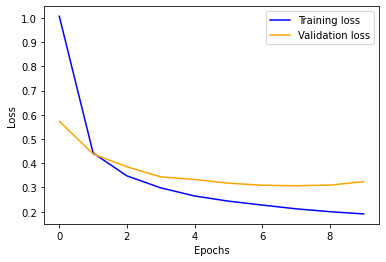

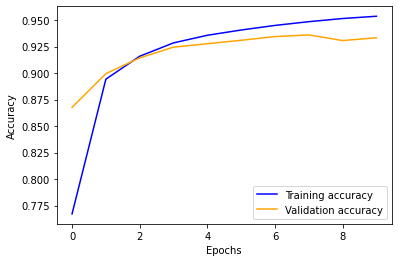

In [ ]:
plt.plot(history.history['loss'], label = 'Training loss', color = 'blue')
plt.plot(history.history['val_loss'], label = 'Validation loss', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'], label = 'Training accuracy', color = 'blue')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy', color = 'orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Prediction

In [ ]:
def get_kanji_by_idx(idx):
    return label_map[label_map['index'] == idx]['char'].values[0]

In [ ]:
import random
history.history

print("Evaluate model on test data")
results = model.evaluate(X_test, Y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:

idxs = []

for i in range(100):
    idxs.append(random.randint(1, len(X_test)))
    
prediction = model.predict(X_test[idxs])
print("prediction shape:", prediction.shape)

for i in range(len(prediction)):
    pred_idx = np.argmax(prediction[i])
    true_idx = np.argmax(Y_test[idxs[i]])
    if pred_idx != true_idx:
        print(f"{i}: Predicted {get_kanji_by_idx(pred_idx)} / Original {get_kanji_by_idx(true_idx)}")

Evaluate model on test data
241/241 [==============================] - 7s 28ms/step - loss: 0.3147 - accuracy: 0.9309
test loss, test acc: [0.3147302269935608, 0.9308947324752808]
4/4 [==============================] - 0s 8ms/step
prediction shape: (100, 49)
12: Predicted ゝ / Original て
16: Predicted れ / Original の
46: Predicted ゝ / Original こ
57: Predicted そ / Original せ
73: Predicted へ / Original む
81: Predicted め / Original し
93: Predicted け / Original は
97: Predicted か / Original つ
